In [2]:
#### https://www.kaggle.com/dikshabhati2002/let-s-classify-audio-ml-dl

import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import math
import os
import numpy as np
import seaborn as sns
import json


from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
import catboost as cb

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

#inport custom functions 
sys.path.append('../..')
from functions 

In [24]:
sr = 22050     # sample rate. based on Nyquist frequency, we only care about frequencies up to 10kHz therefor the sample rate will only perserve those frequencies 
n_fft = 2048
hop_length = 512
duration = 30 # length of song to be used (in seconds) 
n_mels=128
samples_per_track = sr * duration
n_mfcc = 20

json_path = r"data.mfcc.json"

In [25]:
# set a path pointing to folder with data
filepath = '/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original'
# folders contain different genres (classes), lets list all the genres
print(list(os.listdir(f'{filepath}/')))

['pop', '.DS_Store', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', '.gitattributes', 'hiphop', 'country', 'jazz']


In [26]:
def save_mfcc(dataset_path, json_path, n_mfcc=n_mfcc, n_fft=n_fft,
             hop_length=hop_length, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(samples_per_track/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=sample_rate)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        S = librosa.feature.melspectrogram(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    hop_length = hop_length, n_mels=n_mels)
                        
                        mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))


                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            #print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)
     

In [27]:
save_mfcc(filepath,json_path,num_segments=10)
#clear_output()

Processing: pop
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 1
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 2
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 3
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 4
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 5
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 6
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 7
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 8
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 9
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00027.wav, segment: 10
/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/pop/pop.00033.wav, segment: 1
/Users/stephen/Flatiron/Phase4/MIR/Da

In [28]:
# loading in the data 
def load_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)

    # convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data['labels'])

    return inputs, targets 

In [29]:
# set up variables 
inputs, targets = load_data(r'/Users/stephen/Flatiron/Phase4/MIR/notebooks/stephen/data.mfcc.json')
inputs.shape

(9986, 130, 20)

In [30]:
# splitting the data 
# input_train, input_test, target_train, target_test
#X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3)
#print(X_train.shape, y_train.shape)

(6990, 130, 20) (6990,)


In [31]:
# CNN

def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"/Users/stephen/Flatiron/Phase4/MIR/notebooks/stephen/data.mfcc.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [32]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [33]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 20, 1)


In [34]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 18, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 9, 64)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 64, 9, 64)        256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 7, 32)         18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 4, 32)        0         
 2D)                                                             
                                                      

In [37]:
adam = optimizers.Adam(learning_rate=1e-4)

In [38]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 200,
                 batch_size = 32)


Epoch 1/200
188/188 [==============================] - 14s 72ms/step - loss: 1.9367 - accuracy: 0.3353 - val_loss: 1.6977 - val_accuracy: 0.4099
Epoch 2/200
188/188 [==============================] - 15s 82ms/step - loss: 1.7684 - accuracy: 0.3769 - val_loss: 1.5884 - val_accuracy: 0.4379
Epoch 3/200
188/188 [==============================] - 14s 74ms/step - loss: 1.6476 - accuracy: 0.4141 - val_loss: 1.4836 - val_accuracy: 0.4780
Epoch 4/200
188/188 [==============================] - 13s 71ms/step - loss: 1.5490 - accuracy: 0.4477 - val_loss: 1.4188 - val_accuracy: 0.5047
Epoch 5/200
188/188 [==============================] - 13s 72ms/step - loss: 1.4821 - accuracy: 0.4702 - val_loss: 1.3793 - val_accuracy: 0.5214
Epoch 6/200
188/188 [==============================] - 13s 72ms/step - loss: 1.4100 - accuracy: 0.4952 - val_loss: 1.2987 - val_accuracy: 0.5487
Epoch 7/200
188/188 [==============================] - 13s 72ms/step - loss: 1.3635 - accuracy: 0.5194 - val_loss: 1.2522 - val_ac

In [39]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 1440x1080 with 0 Axes>

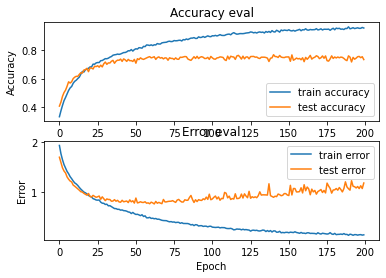

In [40]:
plot_history(hist)

In [41]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 1s 18ms/step - loss: 1.2324 - accuracy: 0.7241
Test accuracy: 0.7240688800811768


In [42]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [43]:
predict(model, X_test[10], y_test[10])

Expected index: 7, Predicted index: [7]
